This following code will be the data setup.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

# Load the data
df = pd.read_csv('56608ee4e4b071e7ea544e04.csv')

print("=== DATA LOADING COMPLETE ===")
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst few rows:")
print(df.head())

print("\n=== DATA SUMMARY ===")
print(df.describe())

print("\n=== MISSING VALUES ===")
print(df.isnull().sum())

print("\n=== UNIQUE VALUES IN KEY COLUMNS ===")
print(f"Sites: {df['Site_ID'].unique()}")
print(f"Time periods: {df['Time'].unique()}")
print(f"Treatments: {df['Treat'].unique()}")
print(f"Dry days range: {df['Dry_Days'].min()} to {df['Dry_Days'].max()}")

# Define nutrients for analysis
nutrients = ['TN', 'NO3', 'NH4', 'Ca', 'Mg', 'K', 'P', 'Fe', 'Mn', 'Cu', 'Zn', 'B', 'S', 'Pb', 'Al', 'Cd']
print(f"\nNutrients to analyze: {nutrients}")

=== DATA LOADING COMPLETE ===
Dataset shape: (80, 20)
Columns: ['Site_ID', 'Time', 'Treat', 'Dry_Days', 'TN', 'NO3', 'NH4', 'Ca', 'Mg', 'K', 'P', 'Fe', 'Mn', 'Cu', 'Zn', 'B', 'S', 'Pb', 'Al', 'Cd']

First few rows:
  Site_ID  Time  Treat  Dry_Days     TN   NO3    NH4       Ca      Mg      K  \
0     C16     1      1        17  11.82  4.40   7.42  2671.48  590.69   5.35   
1     C17     1      1        15  19.43  8.37  11.06  2697.94  566.05   9.66   
2      C2     1      1        23  11.09  4.82   6.27  3070.48  731.81  10.47   
3      C5     1      1         7   3.75  0.73   3.03  2191.05  521.07   6.39   
4      C8     1      1         8  26.15  9.31  16.84  2275.05  567.13   4.56   

        P      Fe      Mn    Cu     Zn     B        S    Pb     Al    Cd  
0   71.12  412.44   58.97  1.01   3.33  0.59  1139.80  0.56  47.66  0.00  
1  100.97  509.77  187.21  1.65   3.92  1.26   367.61  1.82  59.22  0.00  
2   30.49  376.07   96.46  2.49  11.06  3.14   438.98  2.30  70.62  0.00  
3   

This upcoming step now focused on preprocessing the data to identify the pre-flood conditions. This is where the nutrients and water levels are calculated from before.

=== PRE-FLOOD DATA IDENTIFICATION ===
Assumption: Higher 'Dry_Days' values indicate longer periods before flood
This represents the pre-flood soil condition

Dry Days Percentiles: 25th=28.0, 50th=56.0, 75th=84.0

=== PRE-FLOOD CONDITION DISTRIBUTION ===
Pre_Flood_Condition
Very Healthy (Long Dry Period)     21
Moderate (Short Dry Period)        20
Healthy (Moderate Dry Period)      20
At Risk (Very Short Dry Period)    19
Name: count, dtype: int64


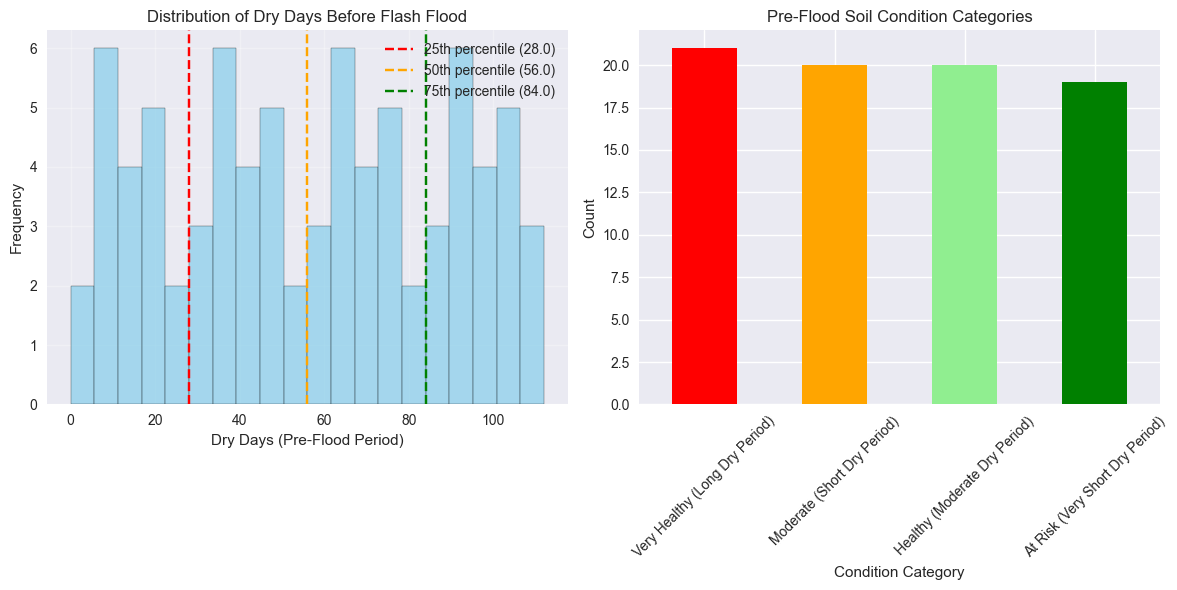

In [5]:

# Create a copy for analysis
df_analysis = df.copy()

# Sort data by site and time to understand the progression
df_analysis = df_analysis.sort_values(['Site_ID', 'Time'])

print("=== PRE-FLOOD DATA IDENTIFICATION ===")
print("Assumption: Higher 'Dry_Days' values indicate longer periods before flood")
print("This represents the pre-flood soil condition")

# Create categories based on dry days (pre-flood condition indicators)
dry_days_percentiles = np.percentile(df_analysis['Dry_Days'], [25, 50, 75])
print(f"\nDry Days Percentiles: 25th={dry_days_percentiles[0]:.1f}, 50th={dry_days_percentiles[1]:.1f}, 75th={dry_days_percentiles[2]:.1f}")

def categorize_pre_flood_condition(dry_days):
    if dry_days >= dry_days_percentiles[2]:
        return 'Very Healthy (Long Dry Period)'
    elif dry_days >= dry_days_percentiles[1]:
        return 'Healthy (Moderate Dry Period)'
    elif dry_days >= dry_days_percentiles[0]:
        return 'Moderate (Short Dry Period)'
    else:
        return 'At Risk (Very Short Dry Period)'

df_analysis['Pre_Flood_Condition'] = df_analysis['Dry_Days'].apply(categorize_pre_flood_condition)

print("\n=== PRE-FLOOD CONDITION DISTRIBUTION ===")
condition_counts = df_analysis['Pre_Flood_Condition'].value_counts()
print(condition_counts)

# Plot distribution
plt.figure(figsize=(12, 6))

# Subplot 1: Dry days distribution
plt.subplot(1, 2, 1)
plt.hist(df_analysis['Dry_Days'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(dry_days_percentiles[0], color='red', linestyle='--', label=f'25th percentile ({dry_days_percentiles[0]:.1f})')
plt.axvline(dry_days_percentiles[1], color='orange', linestyle='--', label=f'50th percentile ({dry_days_percentiles[1]:.1f})')
plt.axvline(dry_days_percentiles[2], color='green', linestyle='--', label=f'75th percentile ({dry_days_percentiles[2]:.1f})')
plt.xlabel('Dry Days (Pre-Flood Period)')
plt.ylabel('Frequency')
plt.title('Distribution of Dry Days Before Flash Flood')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Pre-flood condition categories
plt.subplot(1, 2, 2)
condition_counts.plot(kind='bar', color=['red', 'orange', 'lightgreen', 'green'])
plt.title('Pre-Flood Soil Condition Categories')
plt.xlabel('Condition Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Now we begin the regression system. We need to develop a correlation between the dry land days and the different nutrients to correlate how nutrient levels change to the days approaching to the flash flood day. Each nutrient variable will be displayed seperately in its own cell.

=== ANALYZING TOTAL NITROGEN (TN) ===


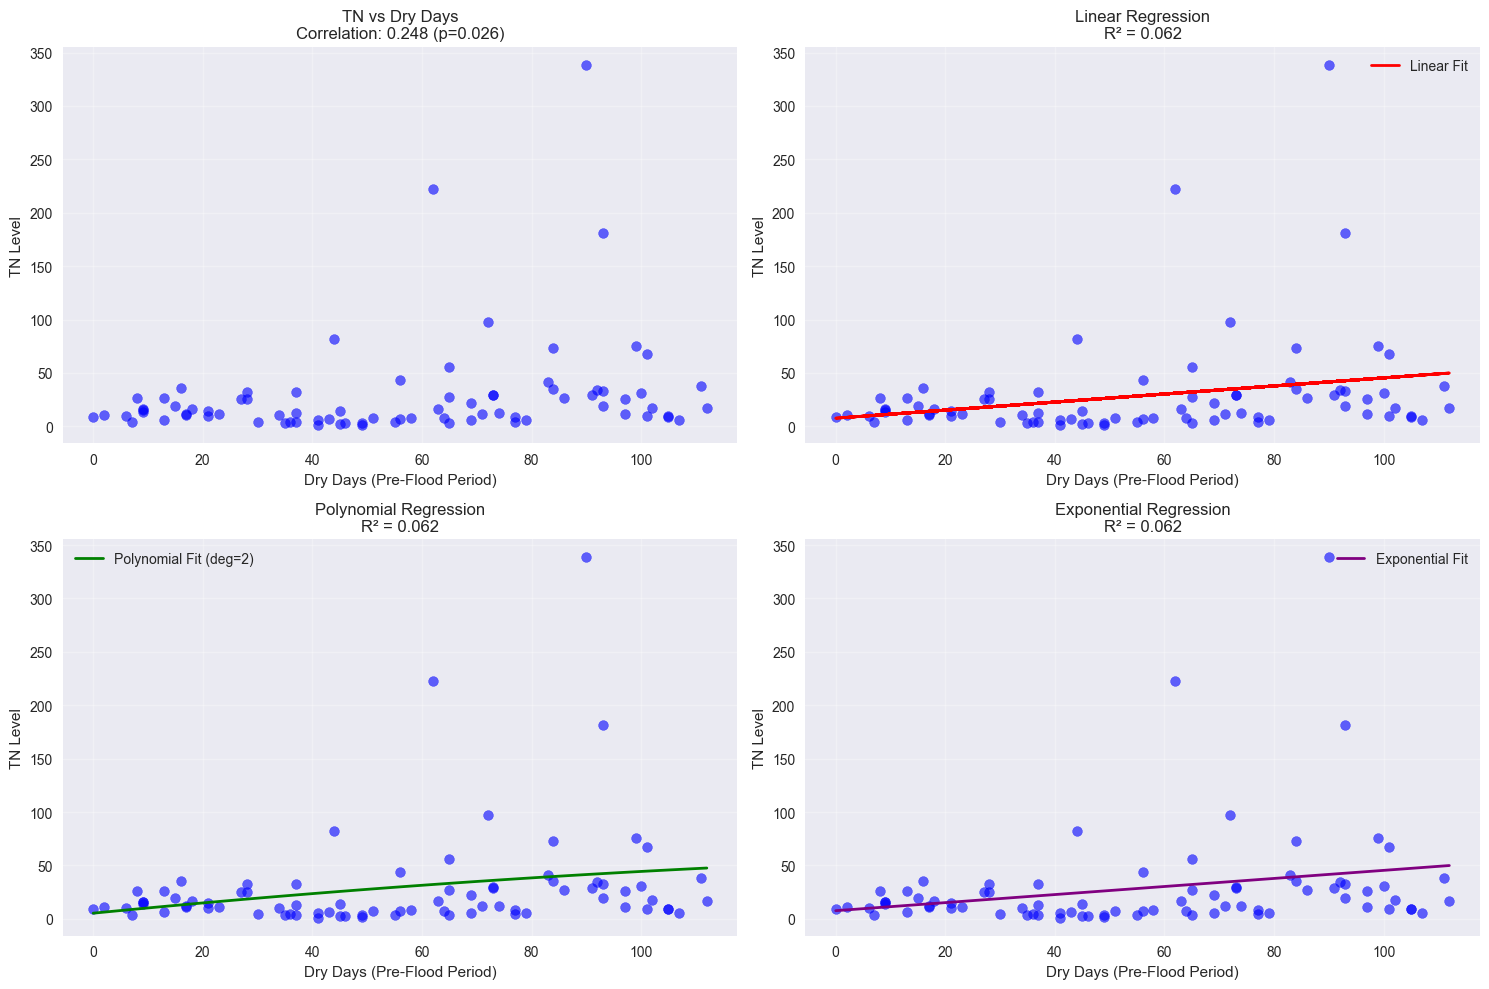


=== TN ANALYSIS SUMMARY ===
Correlation with Dry Days: 0.2484
P-value: 0.0263
Significance: Significant
Linear R²: 0.0617
Polynomial R²: 0.0621
Exponential R²: 0.0617
Best fitting model: Polynomial (R² = 0.0621)


In [6]:

def analyze_nutrient_vs_dry_days(df, nutrient_name):
    """correlation between a nutrient and dry days with multiple regression models"""
    
    # Remove any rows with missing values for this nutrient
    clean_data = df.dropna(subset=[nutrient_name, 'Dry_Days'])
    
    if len(clean_data) < 10:
        print(f"Not enough data for {nutrient_name}")
        return None
    
    x = clean_data['Dry_Days'].values
    y = clean_data[nutrient_name].values
    
    # Calculate correlation
    correlation, p_value = stats.pearsonr(x, y)
    
    # Create the plot
    plt.figure(figsize=(15, 10))
    
    # Main scatter plot
    plt.subplot(2, 2, 1)
    plt.scatter(x, y, alpha=0.6, color='blue', s=50)
    plt.xlabel('Dry Days (Pre-Flood Period)')
    plt.ylabel(f'{nutrient_name} Level')
    plt.title(f'{nutrient_name} vs Dry Days\nCorrelation: {correlation:.3f} (p={p_value:.3f})')
    plt.grid(True, alpha=0.3)
    
    # Linear regression
    plt.subplot(2, 2, 2)
    plt.scatter(x, y, alpha=0.6, color='blue', s=50)
    
    # Fit linear regression
    linear_reg = LinearRegression()
    X_reshaped = x.reshape(-1, 1)
    linear_reg.fit(X_reshaped, y)
    y_pred_linear = linear_reg.predict(X_reshaped)
    
    plt.plot(x, y_pred_linear, color='red', linewidth=2, label='Linear Fit')
    
    # Calculate R²
    r2_linear = r2_score(y, y_pred_linear)
    plt.xlabel('Dry Days (Pre-Flood Period)')
    plt.ylabel(f'{nutrient_name} Level')
    plt.title(f'Linear Regression\nR² = {r2_linear:.3f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Polynomial regression (degree 2)
    plt.subplot(2, 2, 3)
    plt.scatter(x, y, alpha=0.6, color='blue', s=50)
    
    # Fit polynomial regression
    poly_features = PolynomialFeatures(degree=2)
    X_poly = poly_features.fit_transform(X_reshaped)
    poly_reg = LinearRegression()
    poly_reg.fit(X_poly, y)
    
    # Create smooth curve for prediction
    x_smooth = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    x_smooth_poly = poly_features.transform(x_smooth)
    y_pred_poly = poly_reg.predict(x_smooth_poly)
    
    plt.plot(x_smooth, y_pred_poly, color='green', linewidth=2, label='Polynomial Fit (deg=2)')
    
    # Calculate R² for polynomial
    y_pred_poly_orig = poly_reg.predict(X_poly)
    r2_poly = r2_score(y, y_pred_poly_orig)
    plt.xlabel('Dry Days (Pre-Flood Period)')
    plt.ylabel(f'{nutrient_name} Level')
    plt.title(f'Polynomial Regression\nR² = {r2_poly:.3f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Exponential fit attempt
    plt.subplot(2, 2, 4)
    plt.scatter(x, y, alpha=0.6, color='blue', s=50)
    
    try:
        # Exponential function: y = a * exp(b * x) + c
        def exponential_func(x, a, b, c):
            return a * np.exp(b * x) + c
        
        # Initial guess
        popt, _ = curve_fit(exponential_func, x, y, p0=[1, 0.01, np.mean(y)], maxfev=5000)
        y_pred_exp = exponential_func(x_smooth.flatten(), *popt)
        
        plt.plot(x_smooth, y_pred_exp, color='purple', linewidth=2, label='Exponential Fit')
        
        # Calculate R² for exponential
        y_pred_exp_orig = exponential_func(x, *popt)
        r2_exp = r2_score(y, y_pred_exp_orig)
        plt.title(f'Exponential Regression\nR² = {r2_exp:.3f}')
        
    except:
        plt.title('Exponential Regression\n(Failed to fit)')
        r2_exp = 0
    
    plt.xlabel('Dry Days (Pre-Flood Period)')
    plt.ylabel(f'{nutrient_name} Level')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\n=== {nutrient_name} ANALYSIS SUMMARY ===")
    print(f"Correlation with Dry Days: {correlation:.4f}")
    print(f"P-value: {p_value:.4f}")
    print(f"Significance: {'Significant' if p_value < 0.05 else 'Not Significant'}")
    print(f"Linear R²: {r2_linear:.4f}")
    print(f"Polynomial R²: {r2_poly:.4f}")
    print(f"Exponential R²: {r2_exp:.4f}")
    
    # Best model
    best_models = {'Linear': r2_linear, 'Polynomial': r2_poly, 'Exponential': r2_exp}
    best_model = max(best_models, key=best_models.get)
    print(f"Best fitting model: {best_model} (R² = {best_models[best_model]:.4f})")
    
    return {
        'nutrient': nutrient_name,
        'correlation': correlation,
        'p_value': p_value,
        'r2_linear': r2_linear,
        'r2_poly': r2_poly,
        'r2_exp': r2_exp,
        'best_model': best_model,
        'significant': p_value < 0.05
    }



# Analyze Total Nitrogen (TN)
print("=== ANALYZING TOTAL NITROGEN (TN) ===")
tn_results = analyze_nutrient_vs_dry_days(df_analysis, 'TN')

=== ANALYZING NITRATE (NO3) ===


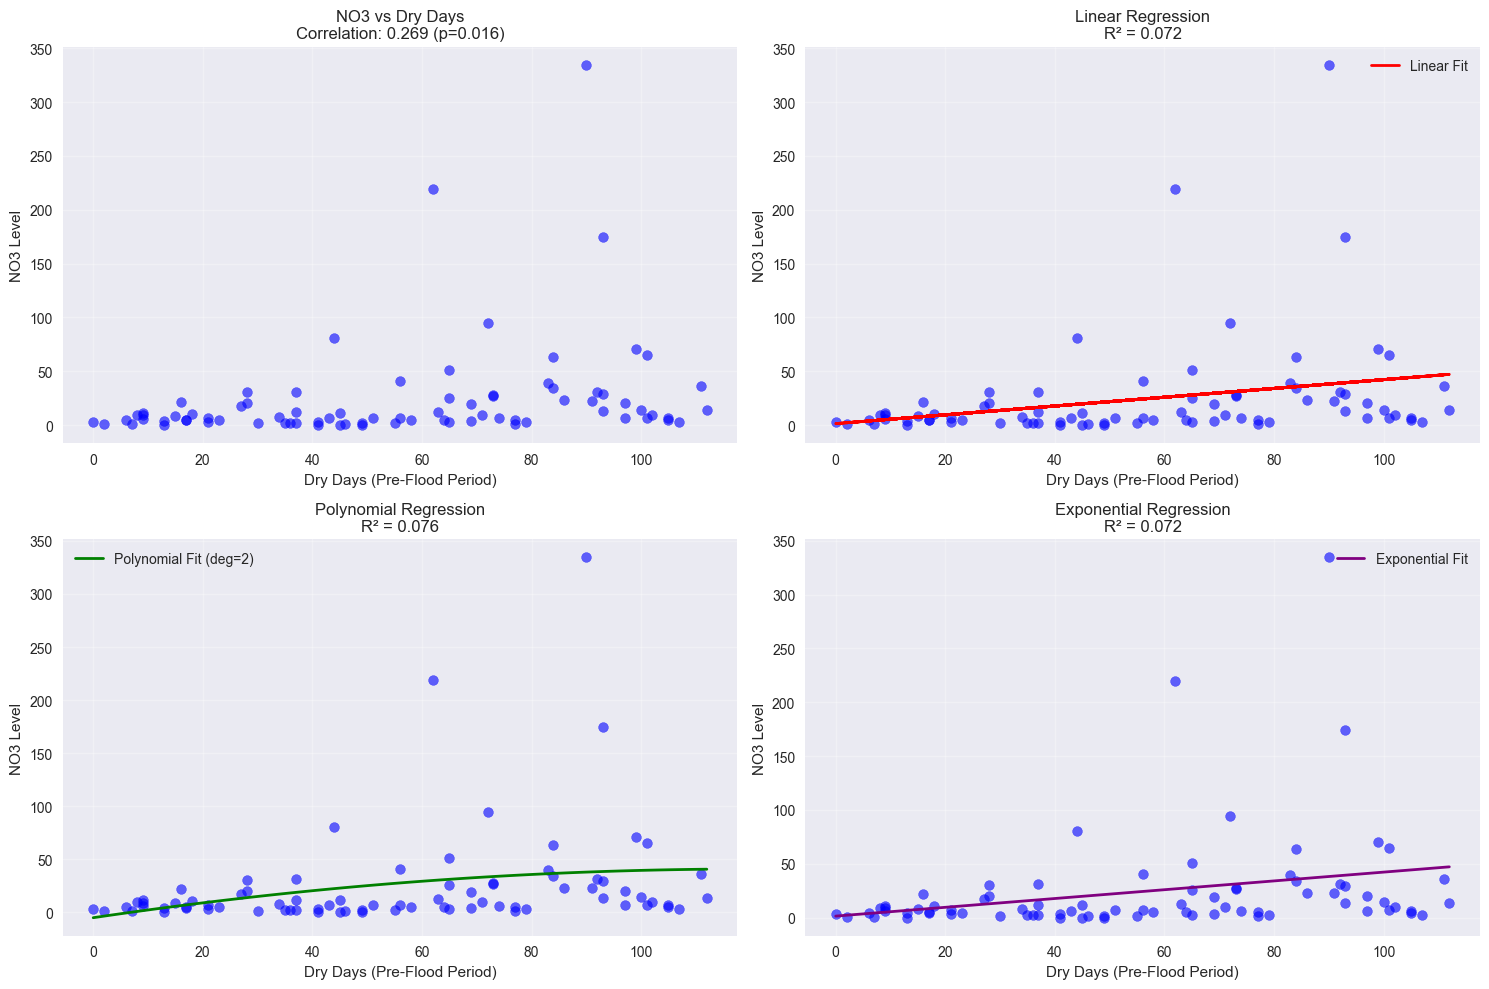


=== NO3 ANALYSIS SUMMARY ===
Correlation with Dry Days: 0.2688
P-value: 0.0159
Significance: Significant
Linear R²: 0.0723
Polynomial R²: 0.0758
Exponential R²: 0.0722
Best fitting model: Polynomial (R² = 0.0758)


In [7]:
#Total NO3 (Nitrate) Level
print("=== ANALYZING NITRATE (NO3) ===")
no3_results = analyze_nutrient_vs_dry_days(df_analysis, 'NO3')

=== ANALYZING AMMONIUM (NH4) ===


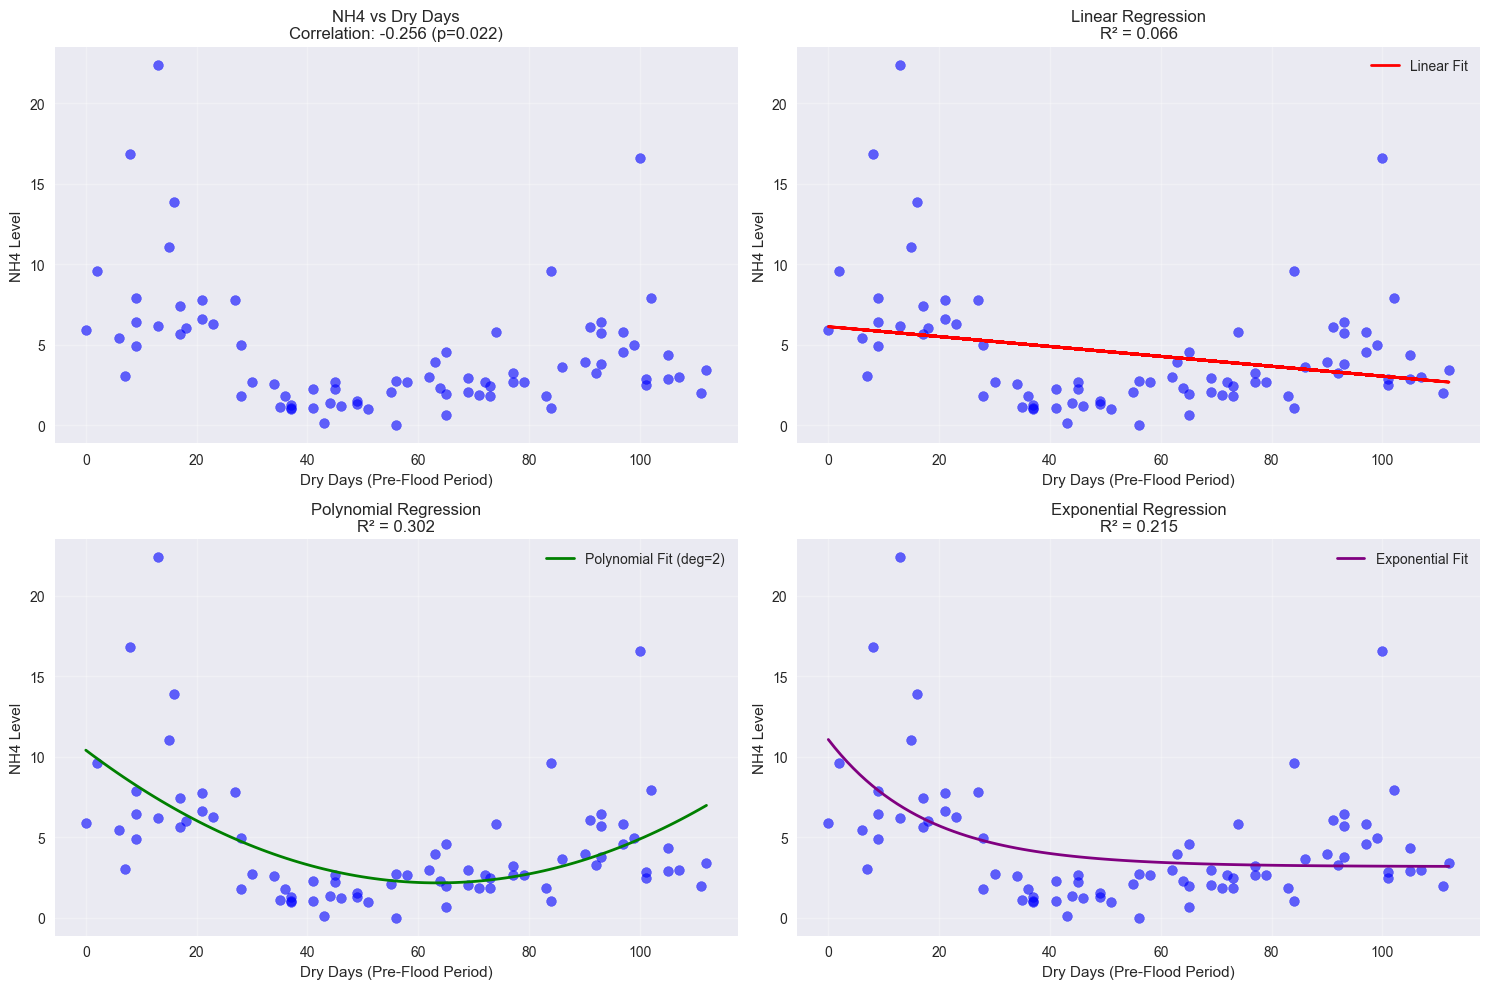


=== NH4 ANALYSIS SUMMARY ===
Correlation with Dry Days: -0.2565
P-value: 0.0217
Significance: Significant
Linear R²: 0.0658
Polynomial R²: 0.3024
Exponential R²: 0.2153
Best fitting model: Polynomial (R² = 0.3024)


In [8]:
# NH4 (Ammonium) Analysis

print("=== ANALYZING AMMONIUM (NH4) ===")
nh4_results = analyze_nutrient_vs_dry_days(df_analysis, 'NH4')

=== ANALYZING PHOSPHORUS (P) ===


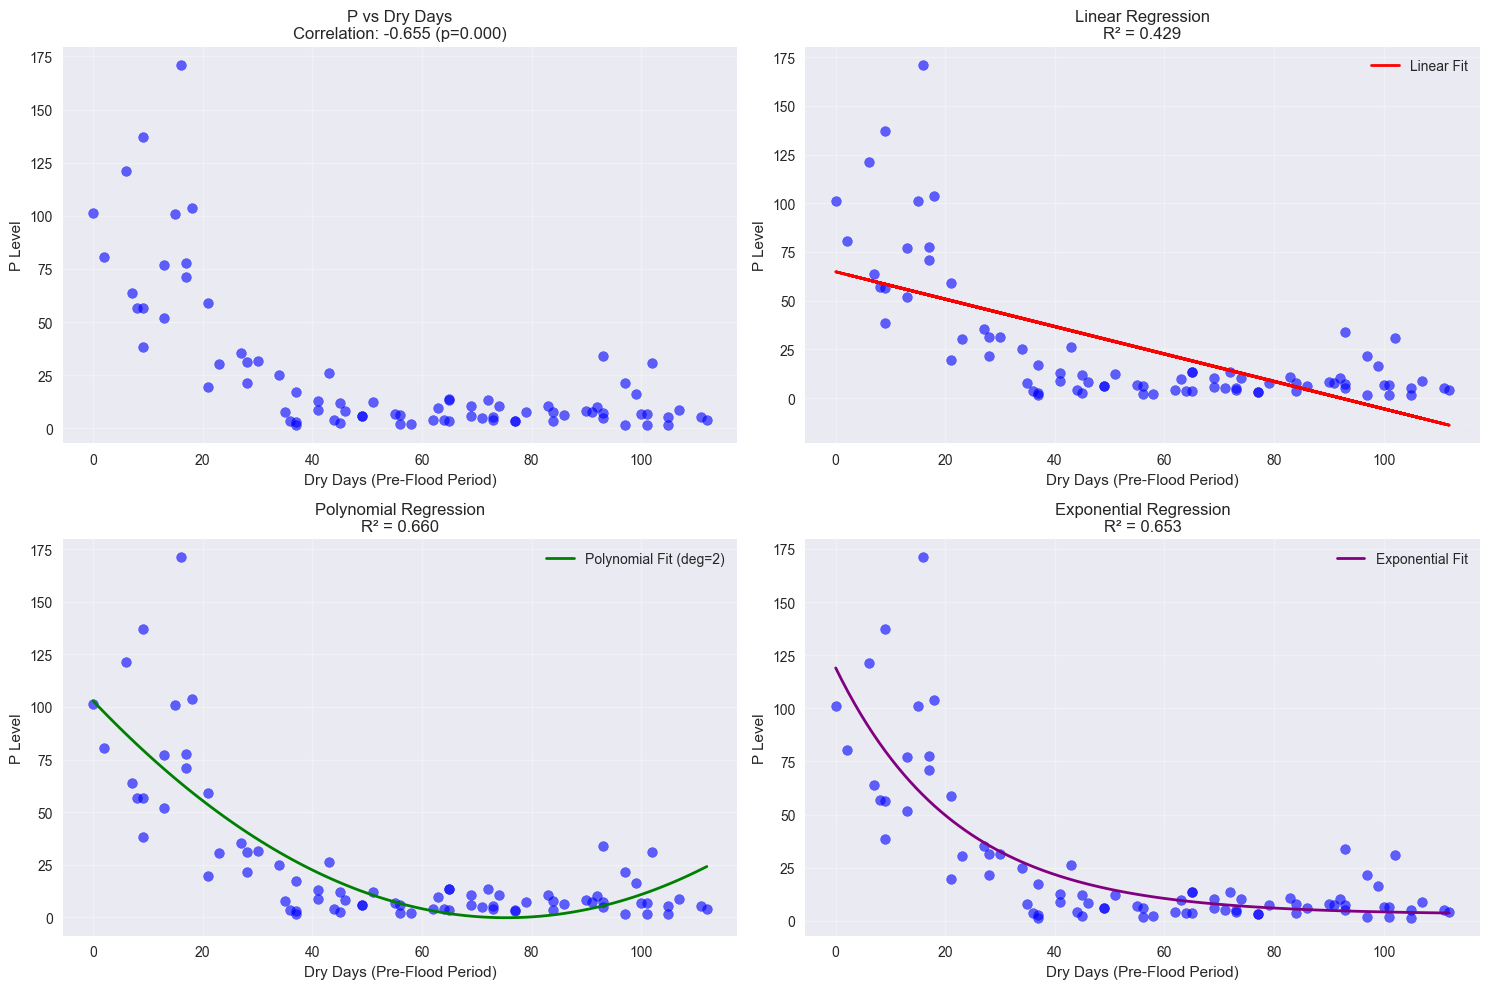


=== P ANALYSIS SUMMARY ===
Correlation with Dry Days: -0.6546
P-value: 0.0000
Significance: Significant
Linear R²: 0.4285
Polynomial R²: 0.6601
Exponential R²: 0.6529
Best fitting model: Polynomial (R² = 0.6601)


In [9]:
#P (Phosphorus) Analysis

print("=== ANALYZING PHOSPHORUS (P) ===")
p_results = analyze_nutrient_vs_dry_days(df_analysis, 'P')

=== ANALYZING POTASSIUM (K) ===


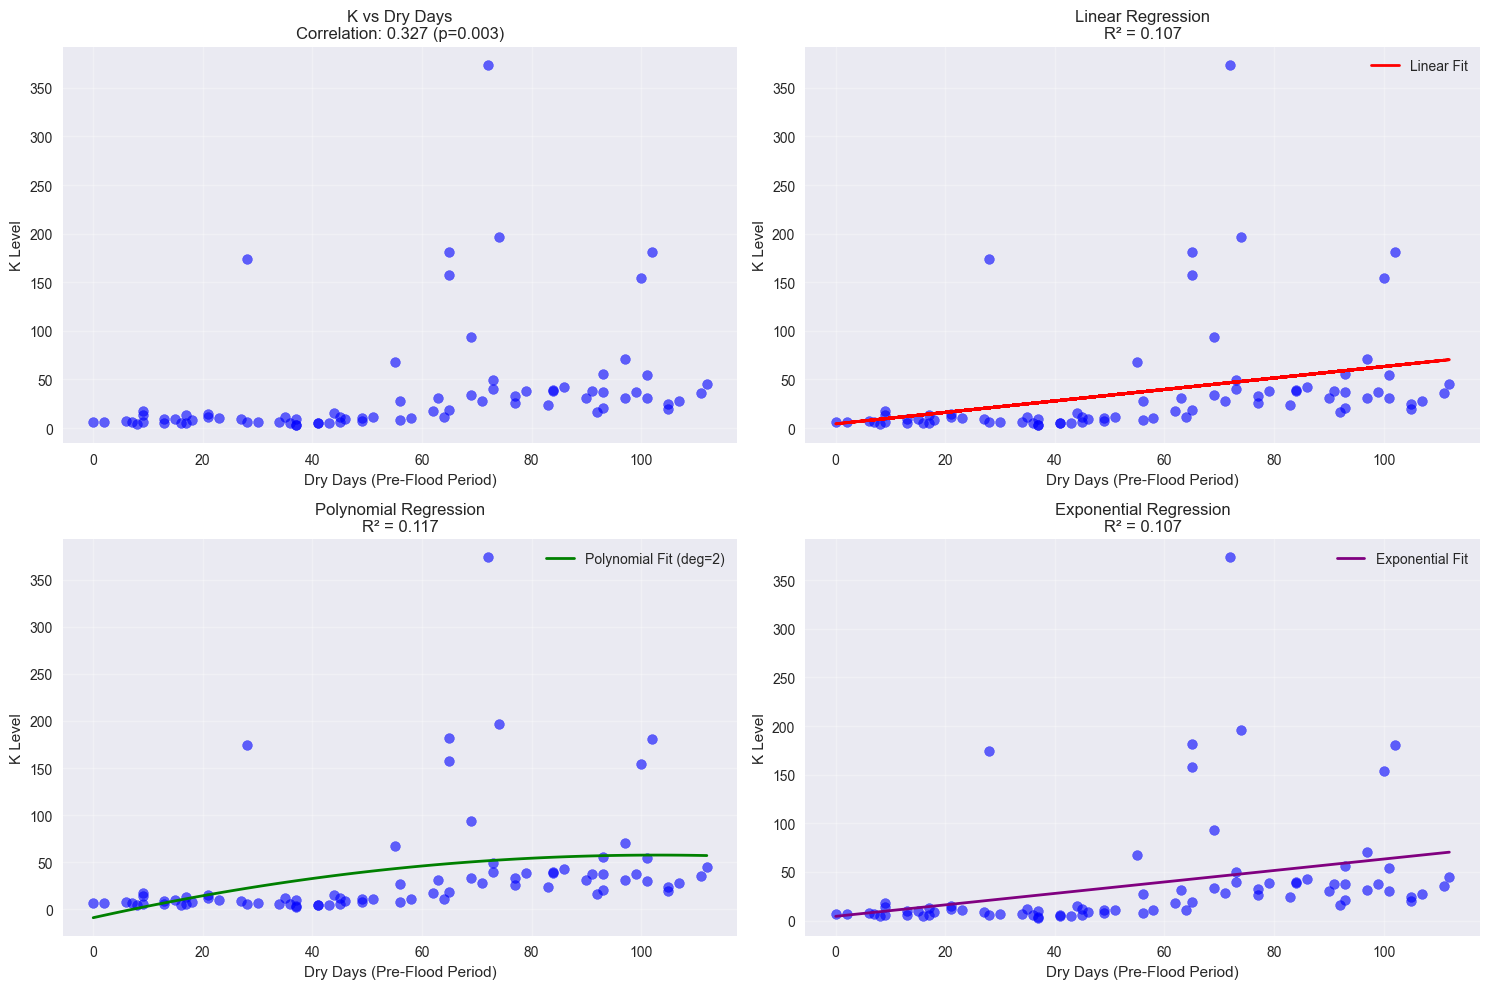


=== K ANALYSIS SUMMARY ===
Correlation with Dry Days: 0.3272
P-value: 0.0031
Significance: Significant
Linear R²: 0.1071
Polynomial R²: 0.1169
Exponential R²: 0.1070
Best fitting model: Polynomial (R² = 0.1169)


In [10]:
#K (Potassium) Analysis

print("=== ANALYZING POTASSIUM (K) ===")
k_results = analyze_nutrient_vs_dry_days(df_analysis, 'K')

=== ANALYZING CALCIUM (Ca) ===


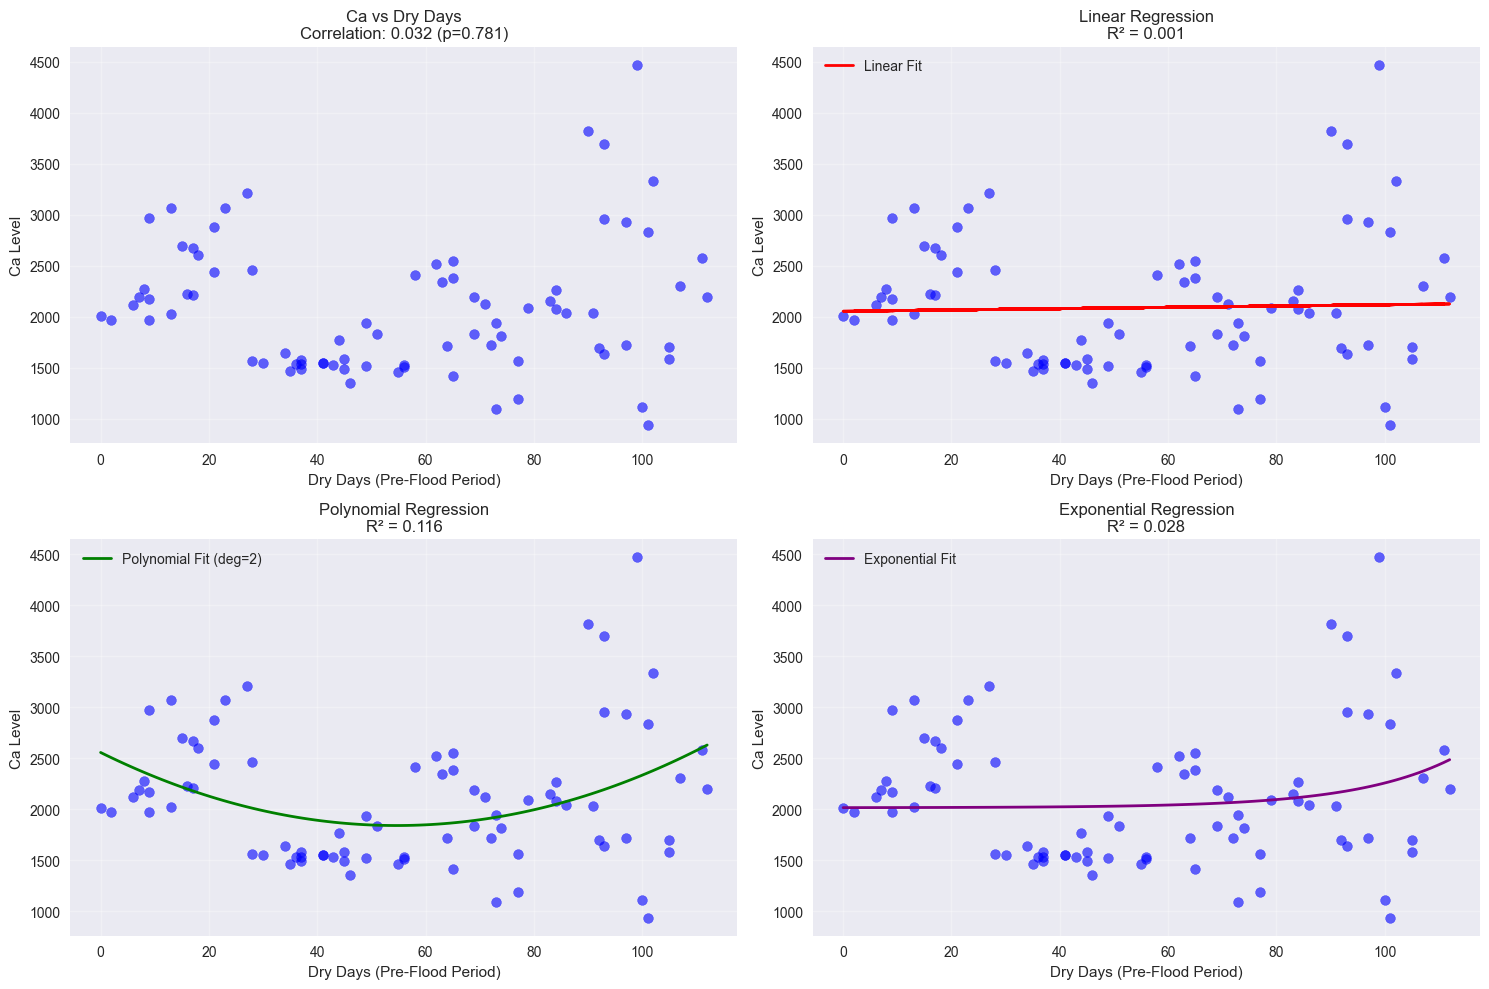


=== Ca ANALYSIS SUMMARY ===
Correlation with Dry Days: 0.0315
P-value: 0.7813
Significance: Not Significant
Linear R²: 0.0010
Polynomial R²: 0.1156
Exponential R²: 0.0276
Best fitting model: Polynomial (R² = 0.1156)


In [11]:
#Ca (Calcium) Analysis

print("=== ANALYZING CALCIUM (Ca) ===")
ca_results = analyze_nutrient_vs_dry_days(df_analysis, 'Ca')

=== ANALYZING MAGNESIUM (Mg) ===


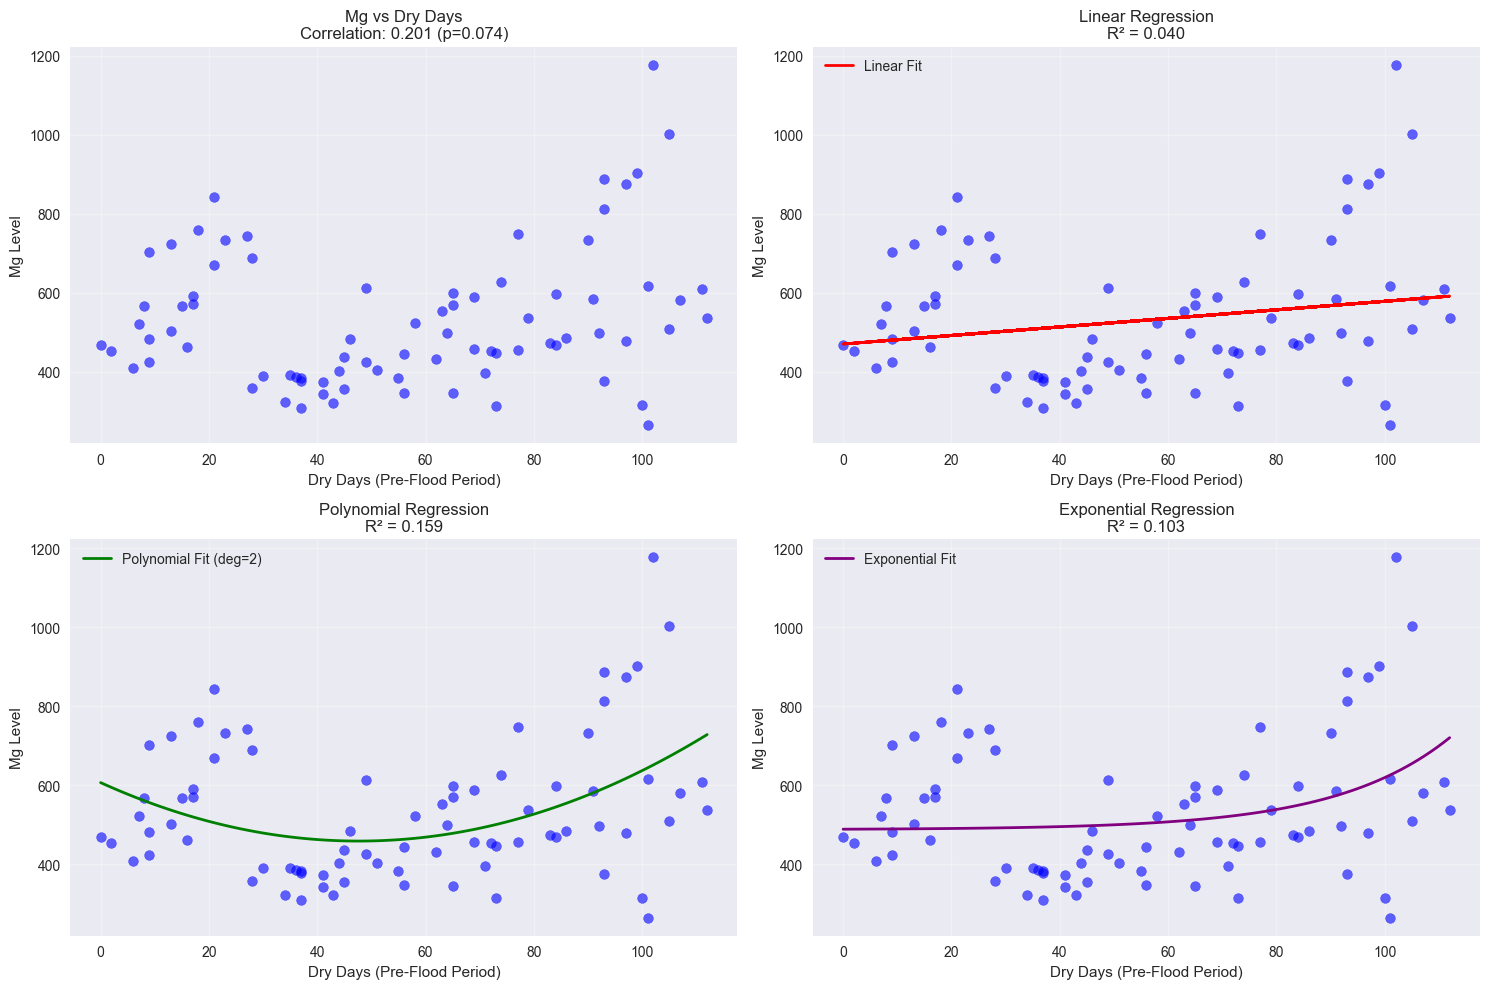


=== Mg ANALYSIS SUMMARY ===
Correlation with Dry Days: 0.2007
P-value: 0.0743
Significance: Not Significant
Linear R²: 0.0403
Polynomial R²: 0.1591
Exponential R²: 0.1028
Best fitting model: Polynomial (R² = 0.1591)


In [12]:
# Mg (Magnesium) Analysis

print("=== ANALYZING MAGNESIUM (Mg) ===")
mg_results = analyze_nutrient_vs_dry_days(df_analysis, 'Mg')

=== ANALYZING IRON (Fe) ===


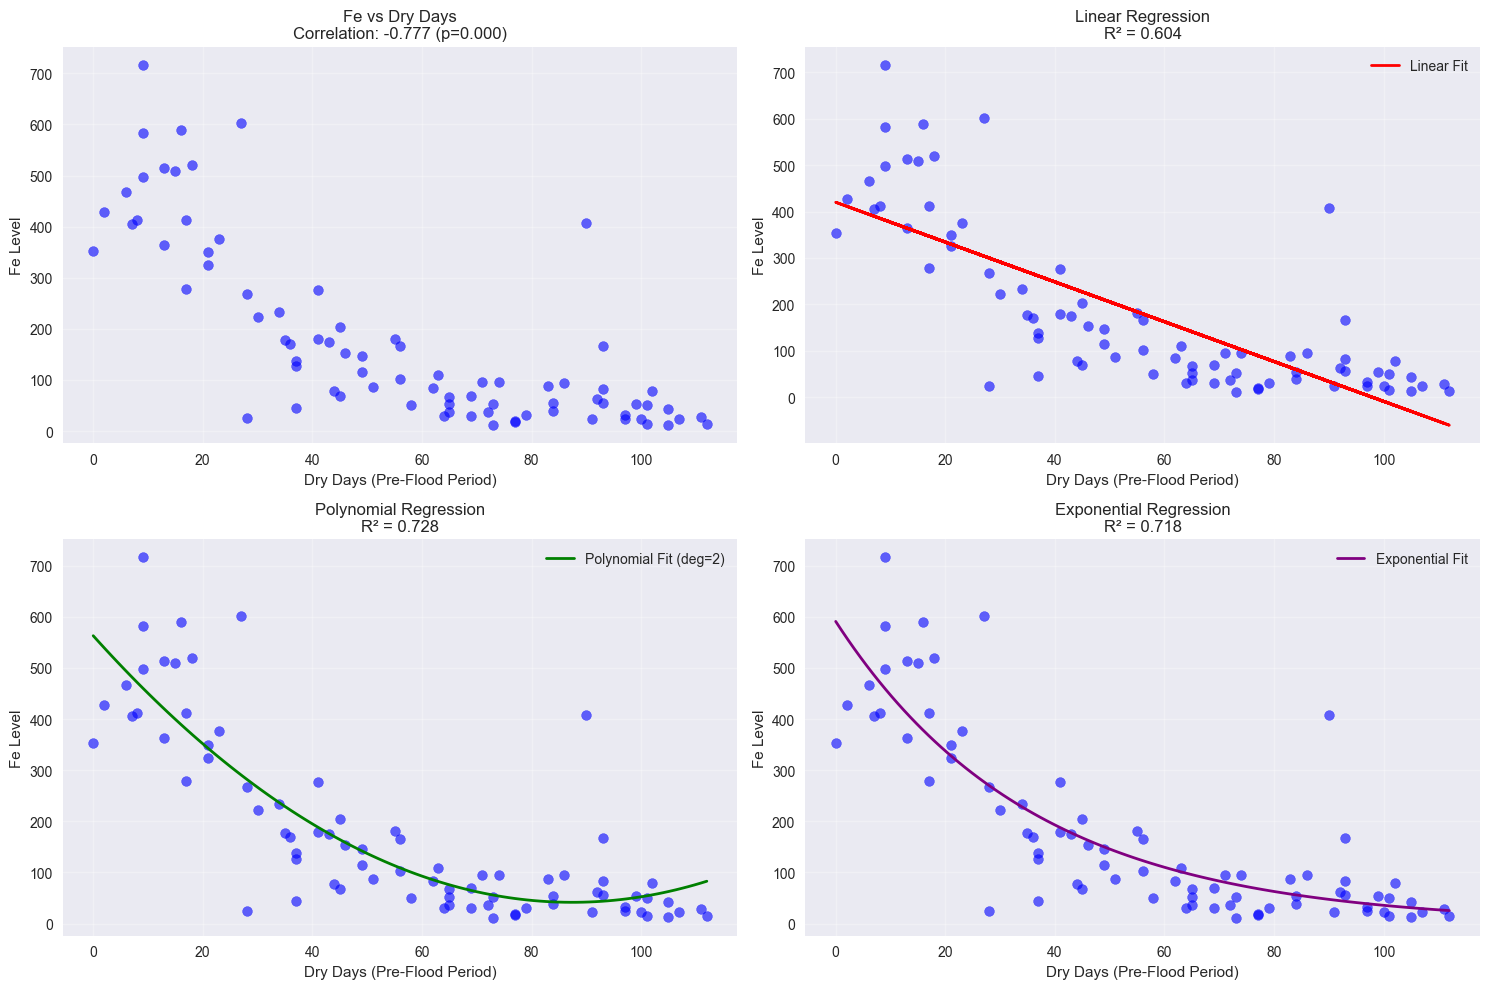


=== Fe ANALYSIS SUMMARY ===
Correlation with Dry Days: -0.7771
P-value: 0.0000
Significance: Significant
Linear R²: 0.6038
Polynomial R²: 0.7280
Exponential R²: 0.7176
Best fitting model: Polynomial (R² = 0.7280)


In [13]:
#Fe (Iron) Analysis

print("=== ANALYZING IRON (Fe) ===")
fe_results = analyze_nutrient_vs_dry_days(df_analysis, 'Fe')


=== ANALYZING Mn ===


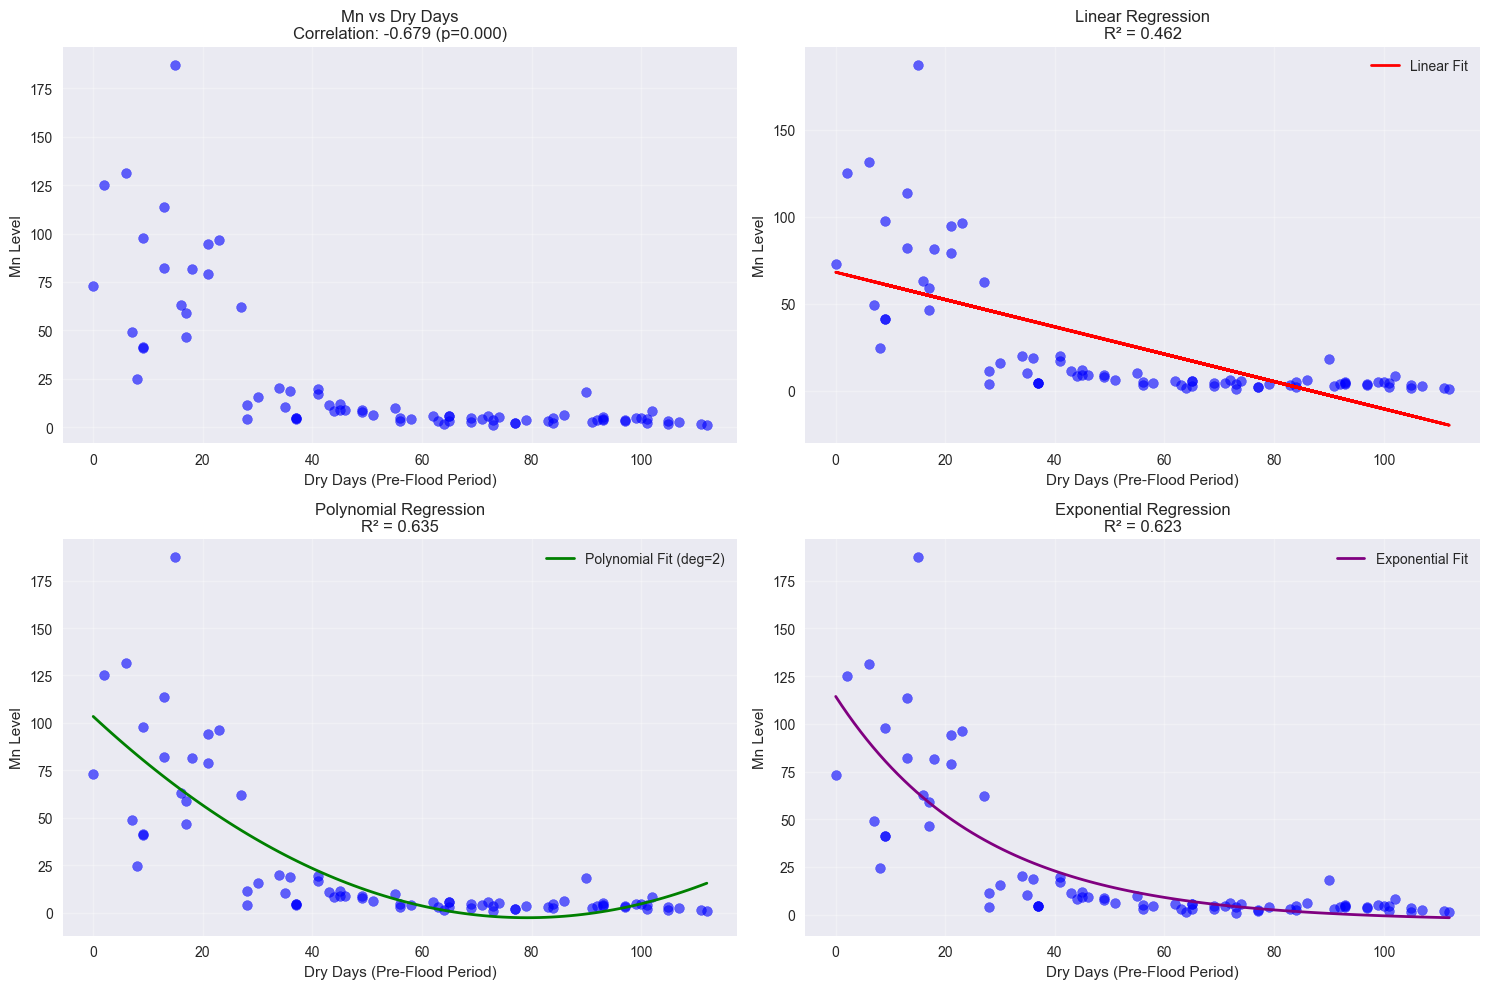


=== Mn ANALYSIS SUMMARY ===
Correlation with Dry Days: -0.6794
P-value: 0.0000
Significance: Significant
Linear R²: 0.4616
Polynomial R²: 0.6355
Exponential R²: 0.6233
Best fitting model: Polynomial (R² = 0.6355)

=== ANALYZING Cu ===


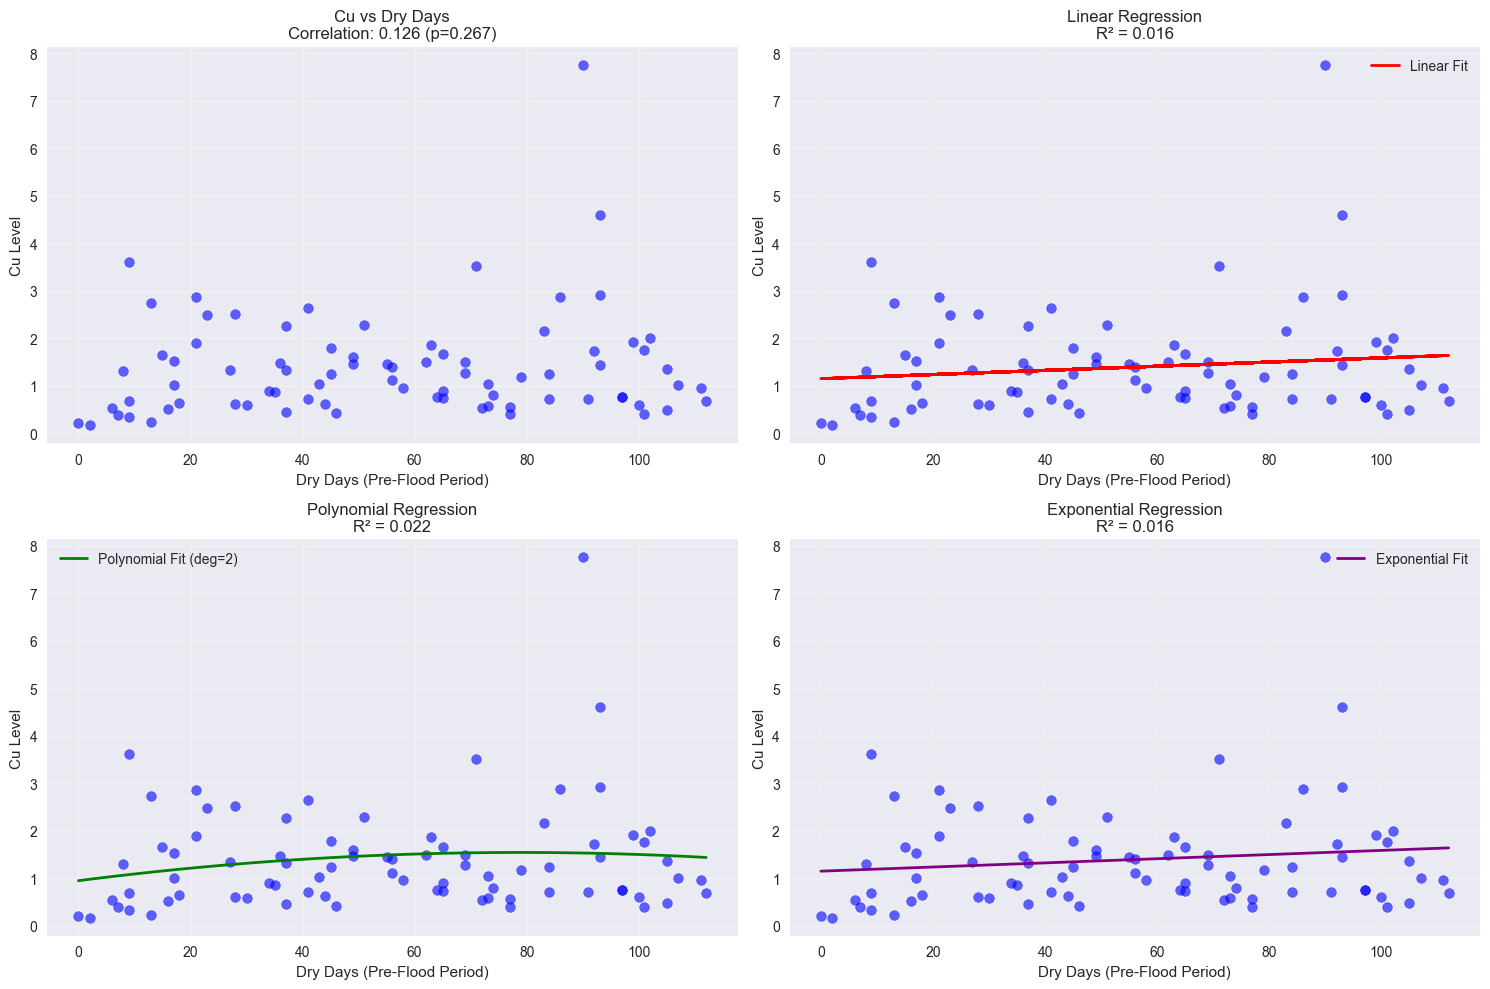


=== Cu ANALYSIS SUMMARY ===
Correlation with Dry Days: 0.1257
P-value: 0.2666
Significance: Not Significant
Linear R²: 0.0158
Polynomial R²: 0.0219
Exponential R²: 0.0158
Best fitting model: Polynomial (R² = 0.0219)

=== ANALYZING Zn ===


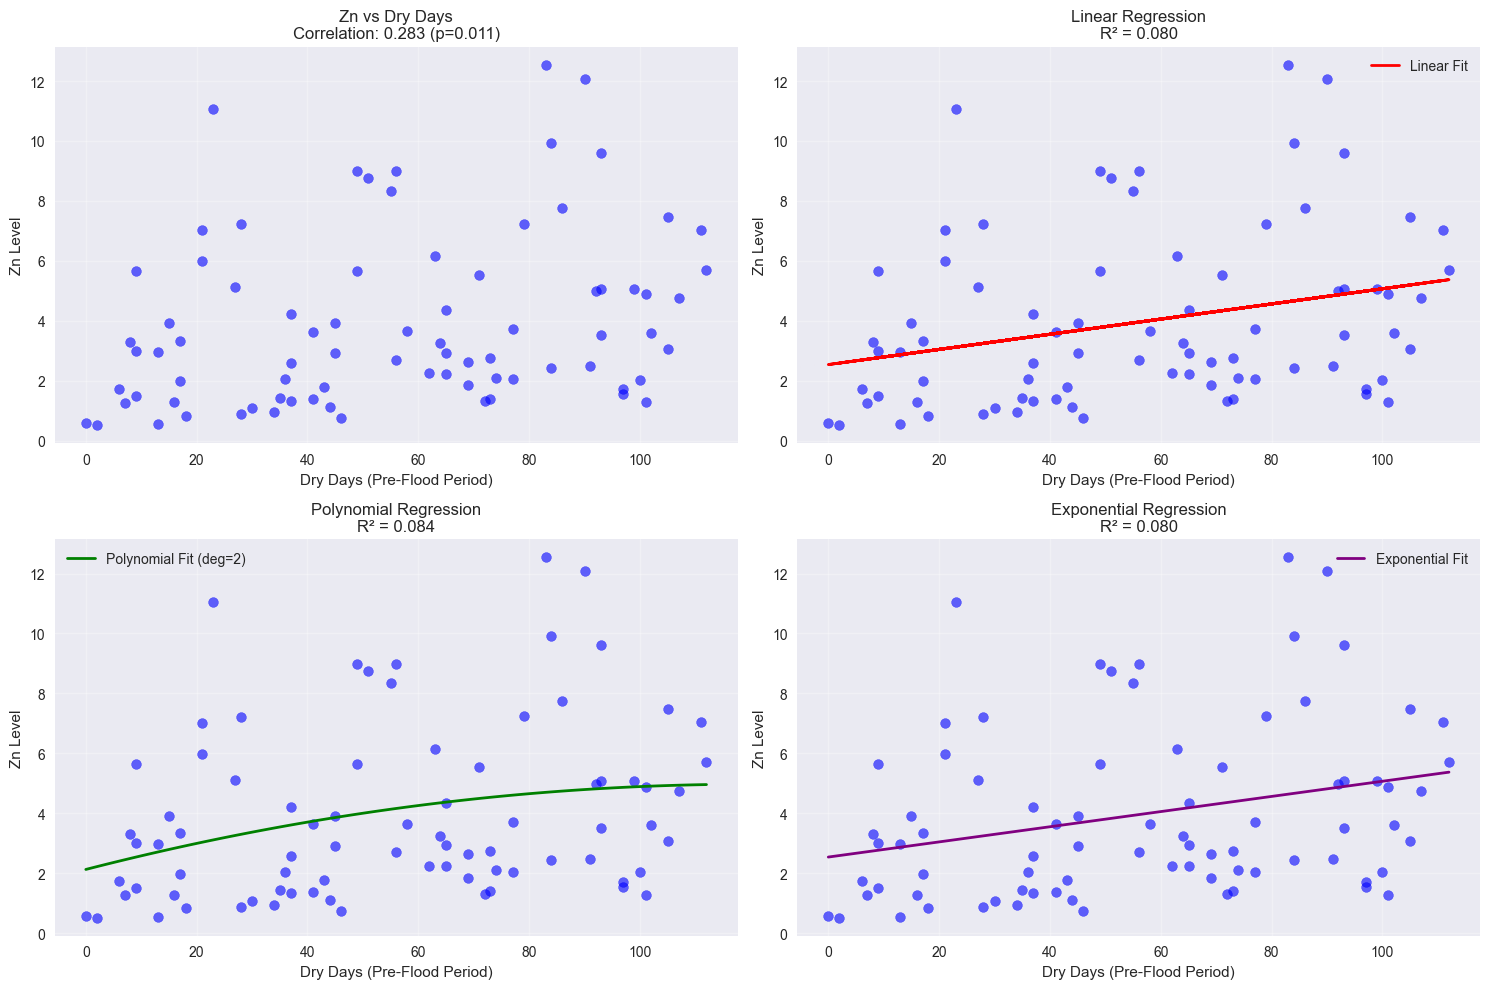


=== Zn ANALYSIS SUMMARY ===
Correlation with Dry Days: 0.2833
P-value: 0.0109
Significance: Significant
Linear R²: 0.0802
Polynomial R²: 0.0842
Exponential R²: 0.0802
Best fitting model: Polynomial (R² = 0.0842)

=== ANALYZING B ===


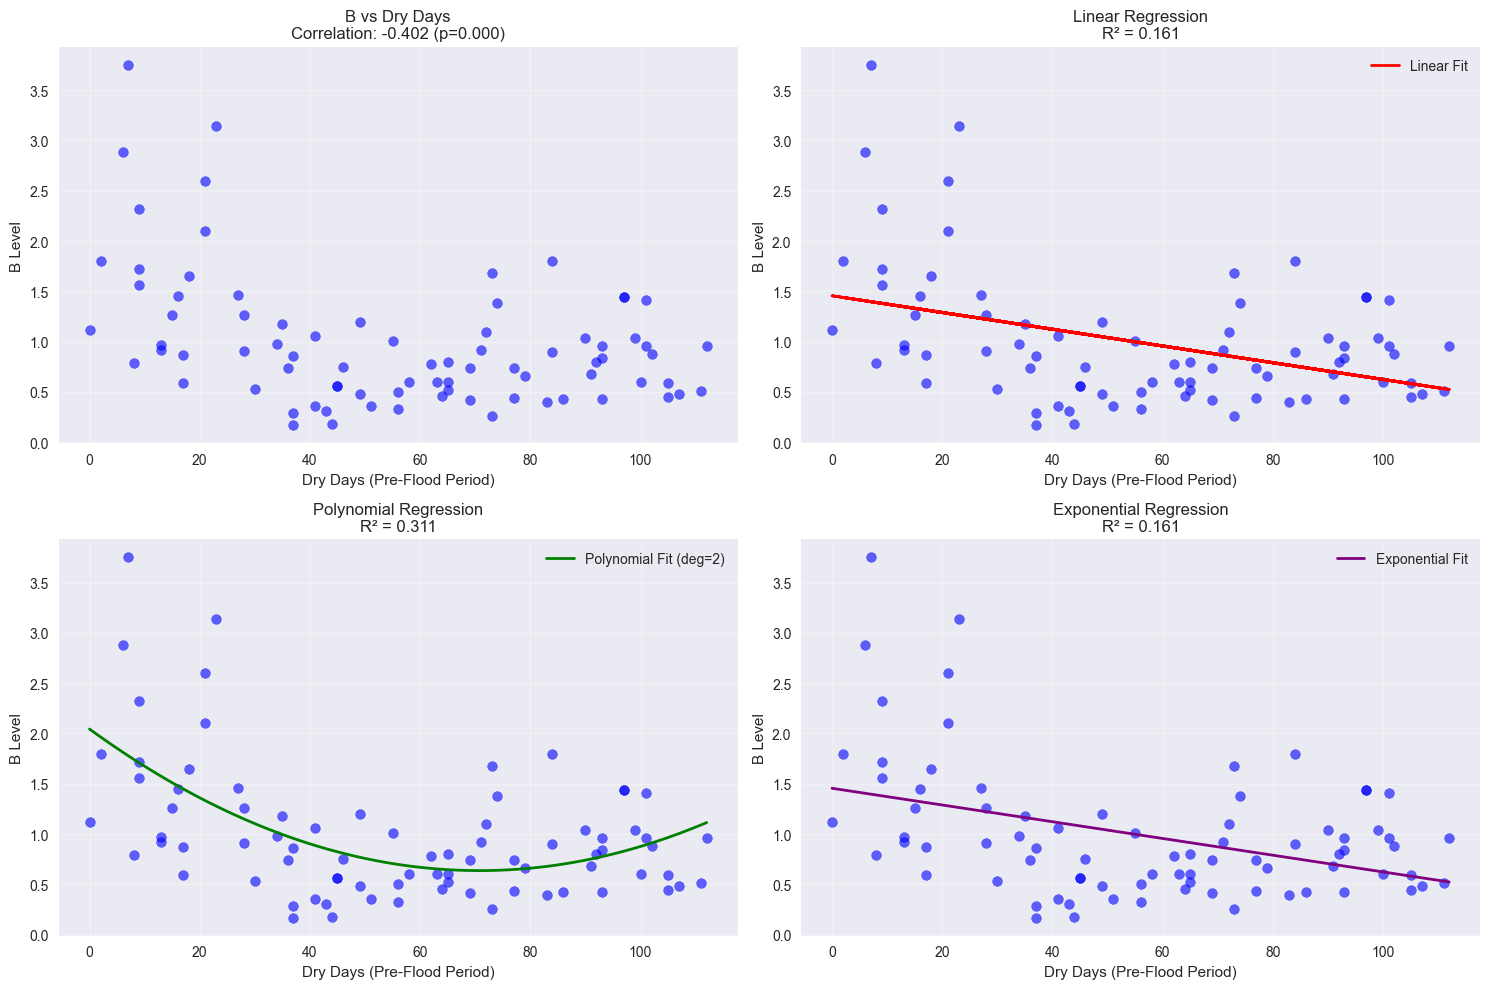


=== B ANALYSIS SUMMARY ===
Correlation with Dry Days: -0.4016
P-value: 0.0002
Significance: Significant
Linear R²: 0.1613
Polynomial R²: 0.3109
Exponential R²: 0.1612
Best fitting model: Polynomial (R² = 0.3109)

=== ANALYZING S ===


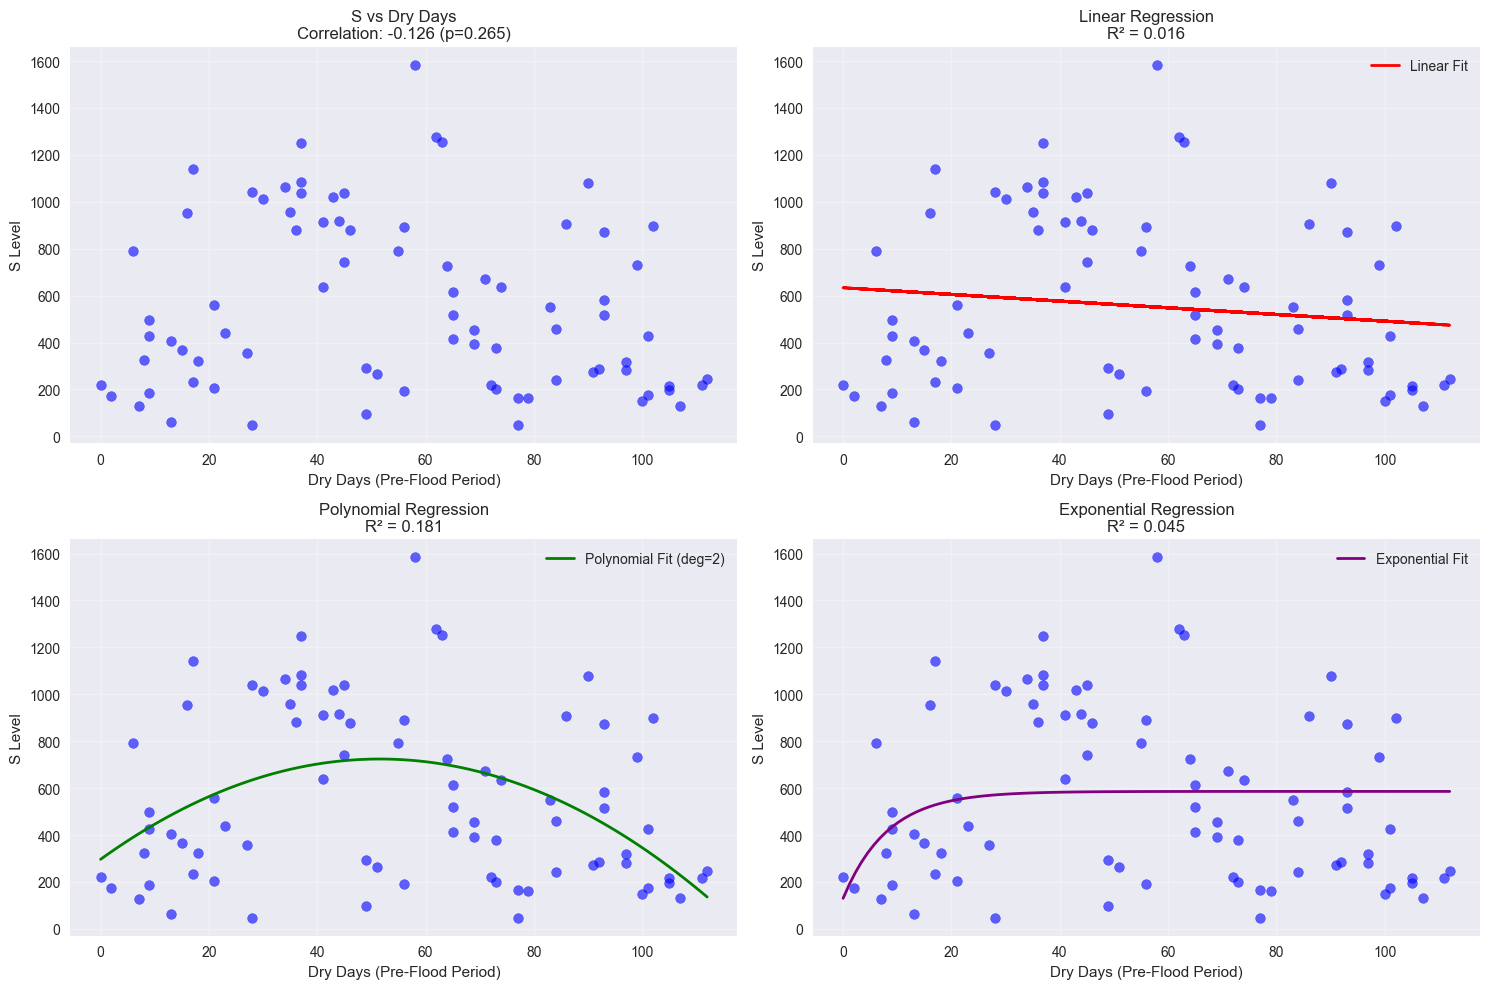


=== S ANALYSIS SUMMARY ===
Correlation with Dry Days: -0.1260
P-value: 0.2655
Significance: Not Significant
Linear R²: 0.0159
Polynomial R²: 0.1808
Exponential R²: 0.0452
Best fitting model: Polynomial (R² = 0.1808)

=== ANALYZING Pb ===


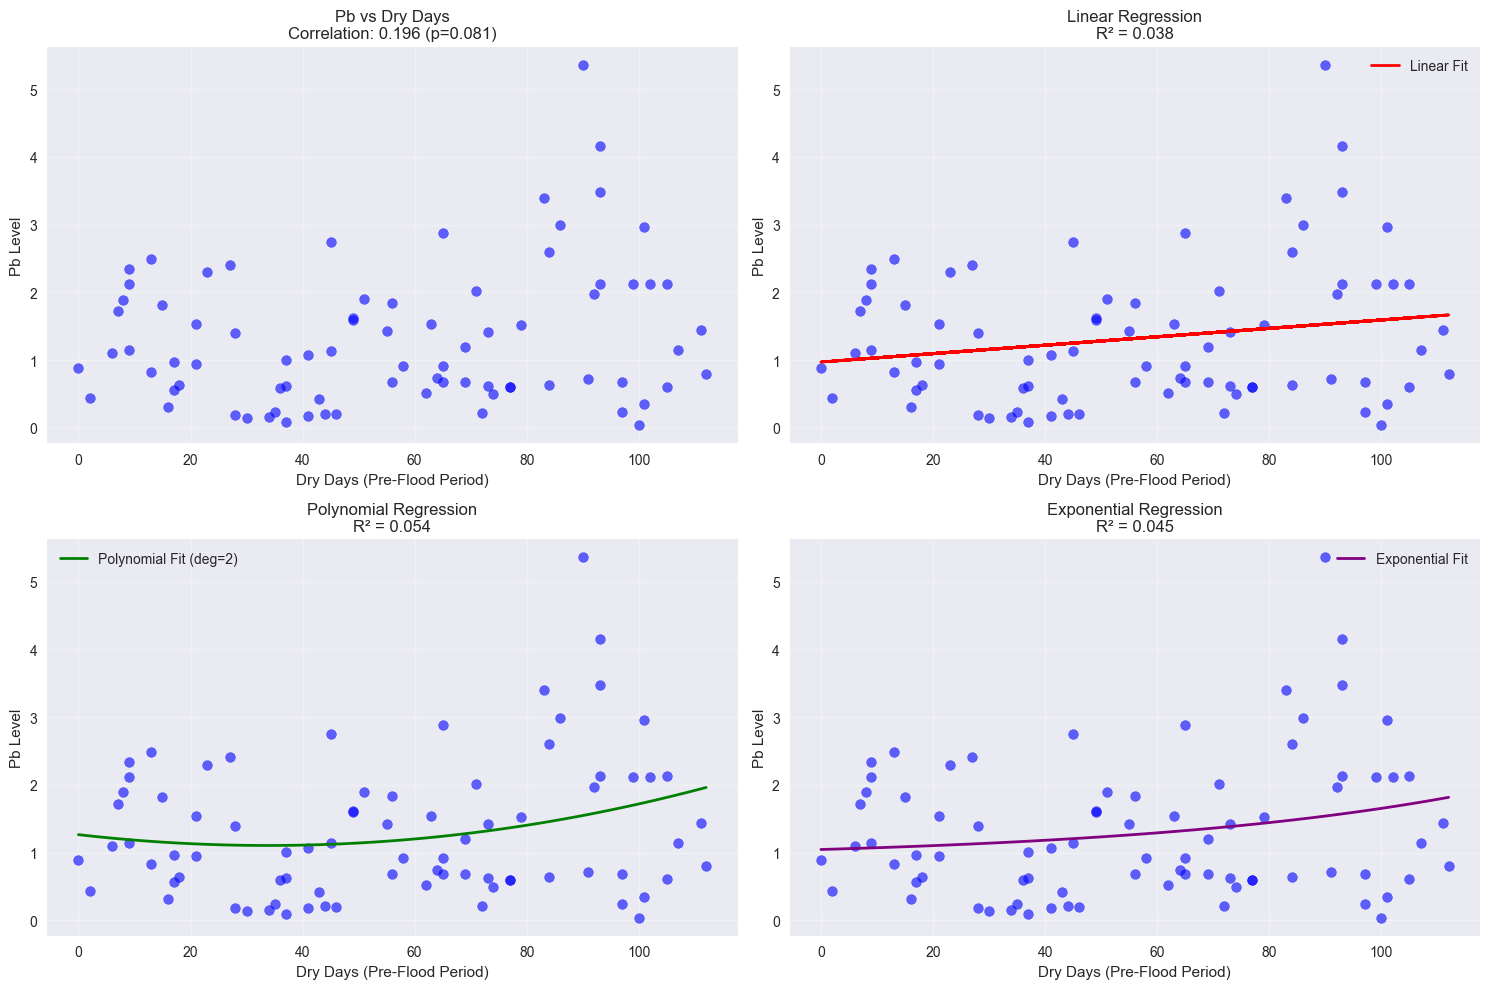


=== Pb ANALYSIS SUMMARY ===
Correlation with Dry Days: 0.1961
P-value: 0.0813
Significance: Not Significant
Linear R²: 0.0385
Polynomial R²: 0.0544
Exponential R²: 0.0445
Best fitting model: Polynomial (R² = 0.0544)

=== ANALYZING Al ===


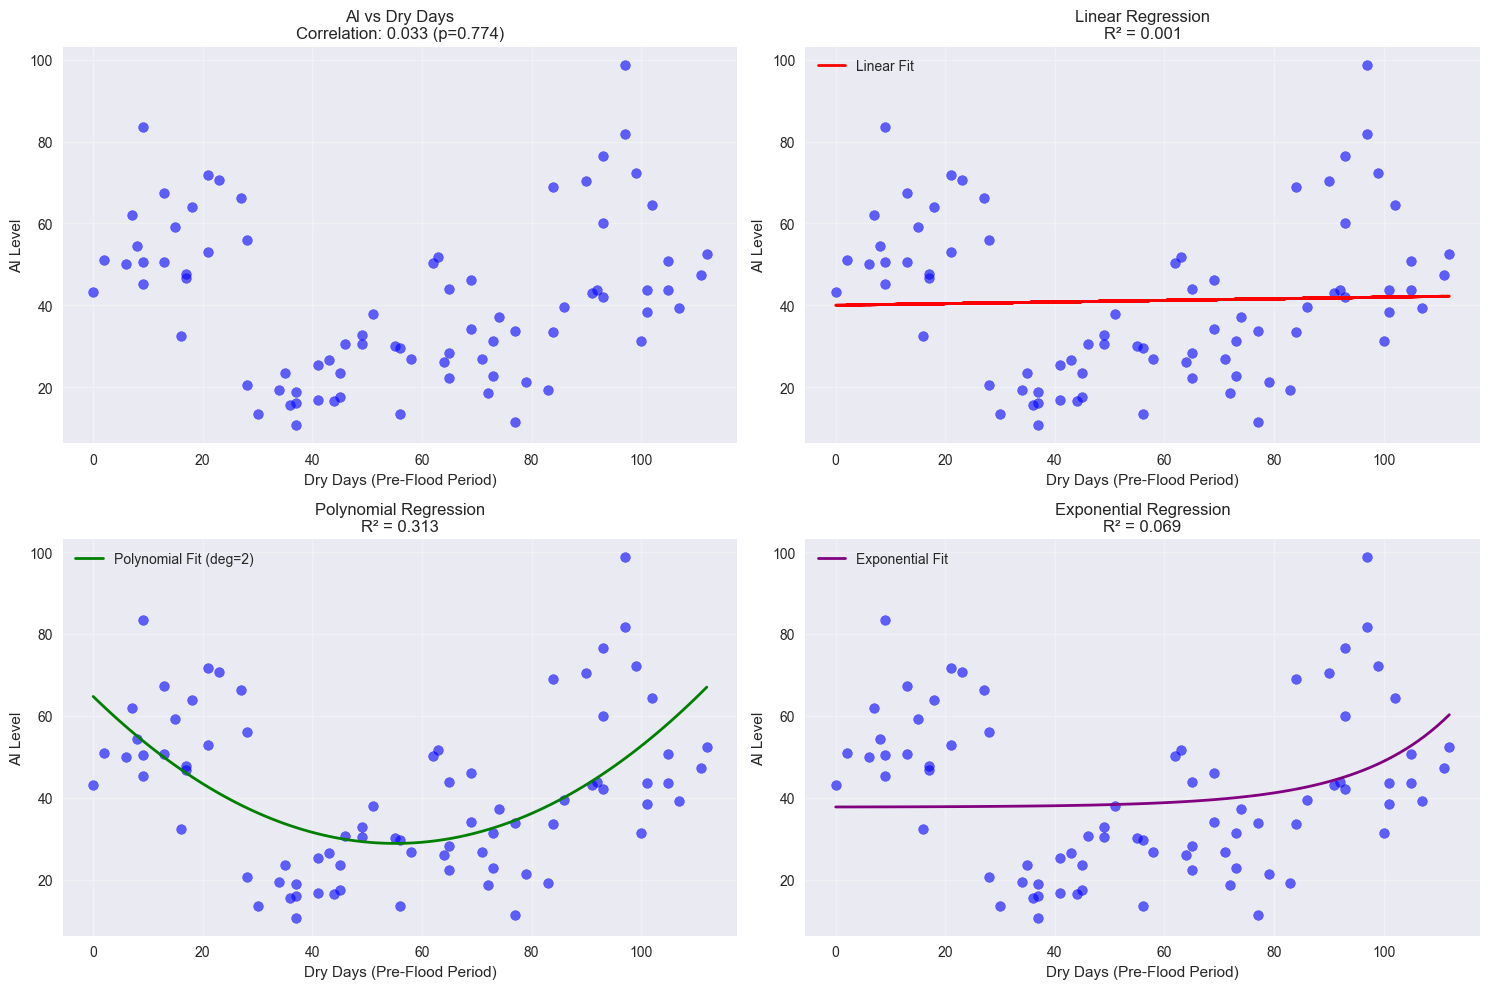


=== Al ANALYSIS SUMMARY ===
Correlation with Dry Days: 0.0326
P-value: 0.7738
Significance: Not Significant
Linear R²: 0.0011
Polynomial R²: 0.3131
Exponential R²: 0.0689
Best fitting model: Polynomial (R² = 0.3131)

=== ANALYZING Cd ===


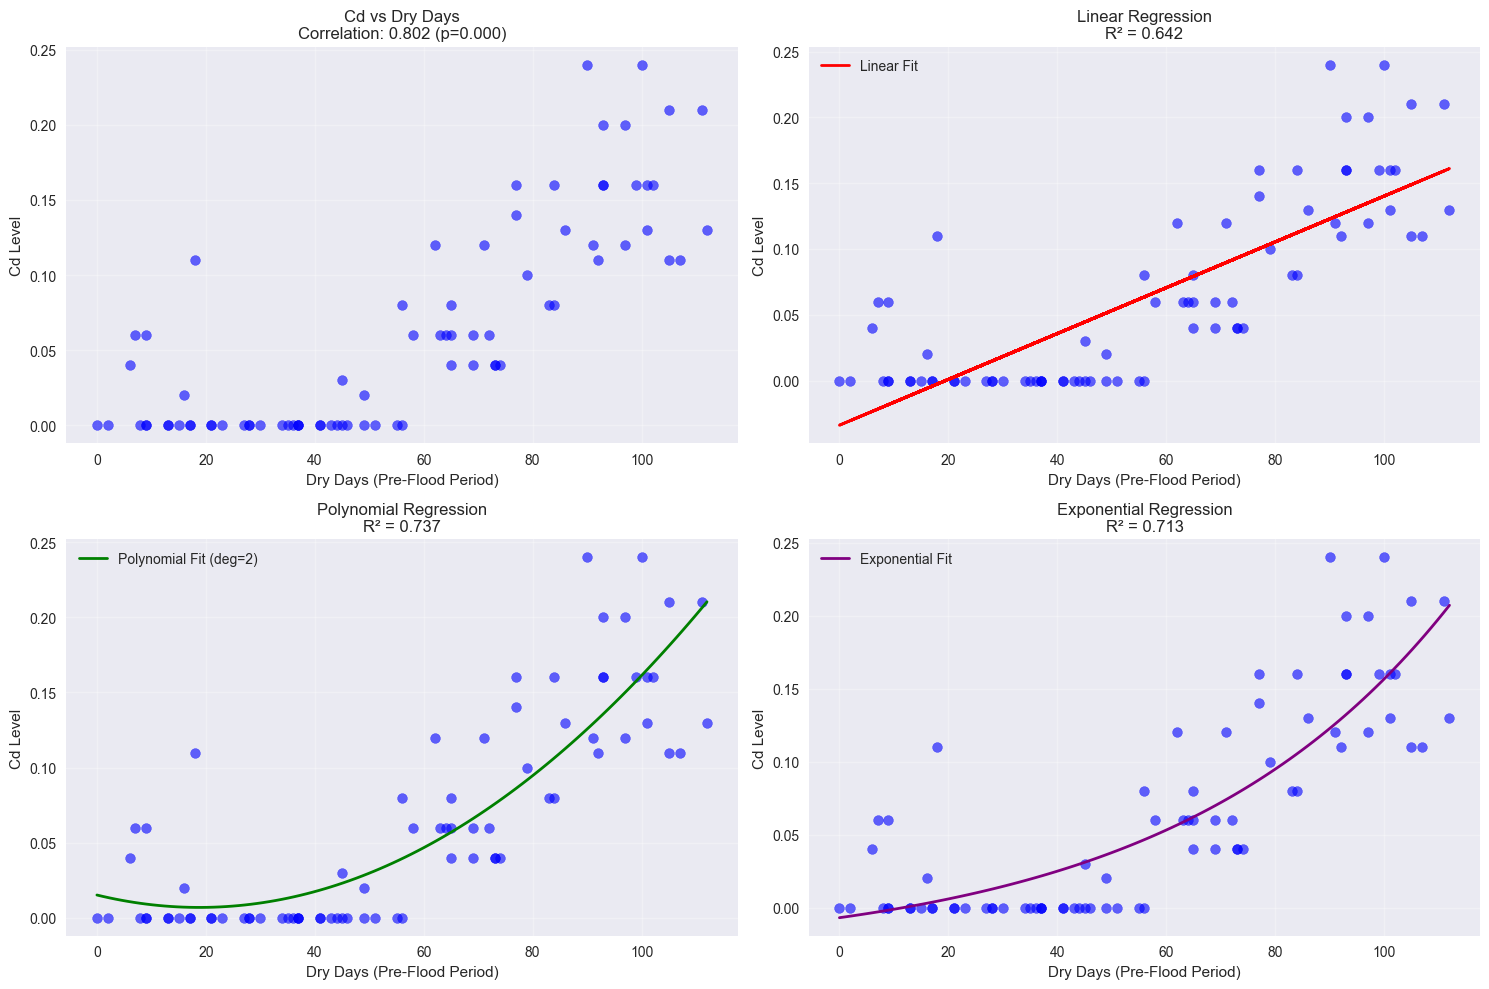


=== Cd ANALYSIS SUMMARY ===
Correlation with Dry Days: 0.8015
P-value: 0.0000
Significance: Significant
Linear R²: 0.6424
Polynomial R²: 0.7369
Exponential R²: 0.7130
Best fitting model: Polynomial (R² = 0.7369)

=== COMPLETED INDIVIDUAL NUTRIENT ANALYSIS ===
Analyzed 16 nutrients successfully


In [14]:
#Remaining Nutrients Analysis

# Analyze remaining nutrients
remaining_nutrients = ['Mn', 'Cu', 'Zn', 'B', 'S', 'Pb', 'Al', 'Cd']
remaining_results = []

for nutrient in remaining_nutrients:
    print(f"\n=== ANALYZING {nutrient} ===")
    result = analyze_nutrient_vs_dry_days(df_analysis, nutrient)
    if result:
        remaining_results.append(result)

# Store all results
all_results = []
for result in [tn_results, no3_results, nh4_results, p_results, k_results, ca_results, mg_results, fe_results] + remaining_results:
    if result:
        all_results.append(result)

print(f"\n=== COMPLETED INDIVIDUAL NUTRIENT ANALYSIS ===")
print(f"Analyzed {len(all_results)} nutrients successfully")

In [15]:
for result in all_results:
   print(result)

{'nutrient': 'TN', 'correlation': np.float64(0.2483875913944738), 'p_value': np.float64(0.026308863613637747), 'r2_linear': 0.06169639555874806, 'r2_poly': 0.06213491585801734, 'r2_exp': 0.06169468020053248, 'best_model': 'Polynomial', 'significant': np.True_}
{'nutrient': 'NO3', 'correlation': np.float64(0.26879533025852453), 'p_value': np.float64(0.015913663701397712), 'r2_linear': 0.0722509295687892, 'r2_poly': 0.07577698947634104, 'r2_exp': 0.07224847225836495, 'best_model': 'Polynomial', 'significant': np.True_}
{'nutrient': 'NH4', 'correlation': np.float64(-0.2564606758476996), 'p_value': np.float64(0.02165861970570232), 'r2_linear': 0.06577207825625875, 'r2_poly': 0.30242298129899736, 'r2_exp': 0.21526579753324437, 'best_model': 'Polynomial', 'significant': np.True_}
{'nutrient': 'P', 'correlation': np.float64(-0.6546358146313868), 'p_value': np.float64(4.5055043009954575e-11), 'r2_linear': 0.42854804979809913, 'r2_poly': 0.6601016243476241, 'r2_exp': 0.6528784399338208, 'best_m

In [19]:
import sqlite3

# Your data as a list of dictionaries
all_results = [
   {'nutrient': 'TN', 'correlation': 0.2483875913944738, 'p_value': 0.026308863613637747, 'r2_linear': 0.06169639555874806, 'r2_poly': 0.06213491585801734, 'r2_exp': 0.06169468020053248, 'best_model': 'Polynomial', 'significant': True},
   {'nutrient': 'NO3', 'correlation': 0.26879533025852453, 'p_value': 0.015913663701397712, 'r2_linear': 0.0722509295687892, 'r2_poly': 0.07577698947634104, 'r2_exp': 0.07224847225836495, 'best_model': 'Polynomial', 'significant': True},
   {'nutrient': 'NH4', 'correlation': -0.2564606758476996, 'p_value': 0.02165861970570232, 'r2_linear': 0.06577207825625875, 'r2_poly': 0.30242298129899736, 'r2_exp': 0.21526579753324437, 'best_model': 'Polynomial', 'significant': True},
   {'nutrient': 'P', 'correlation': -0.6546358146313868, 'p_value': 4.5055043009954575e-11, 'r2_linear': 0.42854804979809913, 'r2_poly': 0.6601016243476241, 'r2_exp': 0.6528784399338208, 'best_model': 'Polynomial', 'significant': True},
   {'nutrient': 'K', 'correlation': 0.32718744143023526, 'p_value': 0.003052581128322452, 'r2_linear': 0.10705162182966366, 'r2_poly': 0.11689128222365808, 'r2_exp': 0.10704754131849348, 'best_model': 'Polynomial', 'significant': True},
   {'nutrient': 'Ca', 'correlation': 0.03153272606973395, 'p_value': 0.7812676332303219, 'r2_linear': 0.000994312813389131, 'r2_poly': 0.11563168534969703, 'r2_exp': 0.027595193236095605, 'best_model': 'Polynomial', 'significant': False},
   {'nutrient': 'Mg', 'correlation': 0.20067034313407828, 'p_value': 0.07429303555191058, 'r2_linear': 0.04026858661354871, 'r2_poly': 0.1591319568338041, 'r2_exp': 0.1027606313021957, 'best_model': 'Polynomial', 'significant': False},
   {'nutrient': 'Fe', 'correlation': -0.7770661994762166, 'p_value': 2.3869918812821292e-17, 'r2_linear': 0.6038318783684109, 'r2_poly': 0.7279832738317966, 'r2_exp': 0.7176191833806421, 'best_model': 'Polynomial', 'significant': True},
   {'nutrient': 'Mn', 'correlation': -0.6794336188435371, 'p_value': 4.2499573962405436e-12, 'r2_linear': 0.46163004241482497, 'r2_poly': 0.6354745207858828, 'r2_exp': 0.6232809688319925, 'best_model': 'Polynomial', 'significant': True},
   {'nutrient': 'Cu', 'correlation': 0.1256935452412885, 'p_value': 0.26658719401088, 'r2_linear': 0.015798867315323983, 'r2_poly': 0.02194570328900236, 'r2_exp': 0.01579693405140392, 'best_model': 'Polynomial', 'significant': False},
   {'nutrient': 'Zn', 'correlation': 0.2832545213769482, 'p_value': 0.01089636183355902, 'r2_linear': 0.08023312388048398, 'r2_poly': 0.08419791303689927, 'r2_exp': 0.08023007630066159, 'best_model': 'Polynomial', 'significant': True},
   {'nutrient': 'B', 'correlation': -0.4015658102414145, 'p_value': 0.00022261843852025158, 'r2_linear': 0.16125509995484388, 'r2_poly': 0.3108941833438492, 'r2_exp': 0.16124354302031618, 'best_model': 'Polynomial', 'significant': True},
   {'nutrient': 'S', 'correlation': -0.12598714929566152, 'p_value': 0.26546278318872246, 'r2_linear': 0.015872761787647294, 'r2_poly': 0.18081094420534338, 'r2_exp': 0.04516595550822977, 'best_model': 'Polynomial', 'significant': False},
   {'nutrient': 'Pb', 'correlation': 0.19609283669713948, 'p_value': 0.08128617451444577, 'r2_linear': 0.03845240060393107, 'r2_poly': 0.05435734523338487, 'r2_exp': 0.04453255904170894, 'best_model': 'Polynomial', 'significant': False},
   {'nutrient': 'Al', 'correlation': 0.03263464039997327, 'p_value': 0.7738246815415932, 'r2_linear': 0.0010650197540357231, 'r2_poly': 0.31314170696555, 'r2_exp': 0.0689400769662194, 'best_model': 'Polynomial', 'significant': False},
   {'nutrient': 'Cd', 'correlation': 0.8015083056876462, 'p_value': 4.259770441498984e-19, 'r2_linear': 0.642415564086281, 'r2_poly': 0.7369187335008409, 'r2_exp': 0.7129528362531634, 'best_model': 'Polynomial', 'significant': True}
]

# Create SQLite database and table
conn = sqlite3.connect('nutrient_analysis.db')
cursor = conn.cursor()

# Create table
cursor.execute('''
CREATE TABLE IF NOT EXISTS nutrient_results (
   id INTEGER PRIMARY KEY AUTOINCREMENT,
   nutrient TEXT,
   correlation REAL,
   p_value REAL,
   r2_linear REAL,
   r2_poly REAL,
   r2_exp REAL,
   best_model TEXT,
   significant BOOLEAN
)
''')

# Insert data
for result in all_results:
   cursor.execute('''
   INSERT INTO nutrient_results 
   (nutrient, correlation, p_value, r2_linear, r2_poly, r2_exp, best_model, significant)
   VALUES (?, ?, ?, ?, ?, ?, ?, ?)
   ''', (
       result['nutrient'],
       result['correlation'],
       result['p_value'],
       result['r2_linear'],
       result['r2_poly'],
       result['r2_exp'],
       result['best_model'],
       result['significant']
   ))

# Commit and close
conn.commit()
conn.close()

print(f"Successfully inserted {len(all_results)} records into nutrient_analysis.db")

Successfully inserted 16 records into nutrient_analysis.db
